In [11]:
# import modules
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from scipy.ndimage.filters import gaussian_filter1d

In [5]:
# extract frames from videos
def video_to_frames(video_dir, imgs_dir):
    cap = cv2.VideoCapture(video_dir)
    
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 500)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 500)
    
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    count = 0
    
    while cap.isOpened():
        _, frame = cap.read()
        cv2.imwrite(imgs_dir + "/%#05d.jpg" % (count), frame)
        count += 1
        
        if count == video_length:
            cap.release()
            break

In [12]:
# convert RGB to normalized intensity
def rgb_to_intensity(img_path):
    img_rgb = mpimg.imread(img_path)
    x, y, _ = img_rgb.shape

    img_intensity = np.zeros((x, y))
    for i in range(x):
        for j in range(y):
            r, g, b = img_rgb[i][j]
            img_intensity[i][j] = (0xFFFF * r + 0xFF * g + b) / (0xFFFF + 0xFF + 1) / 0xFF
    return img_intensity

In [ ]:
# get video frames
video_to_frames('clip.mp4', './test')

# remove bad frames. Mostly initial and final frames
for img_path in img_paths:
    try: 
        mpimg.imread(img_path)
    except OSError:
        os.remove(img_path)
    else:
        pass

In [ ]:
# asemble images into a data cube: each image is a 2D matrix
img_folder = './test'
img_paths = [os.path.join(img_folder, file_name).replace("\\","/") for file_name in os.listdir(img_folder)]

# get the cube
(x, y, _), z = mpimg.imread(img_paths[0]).shape, len(img_paths)
data_cube = np.zeros((x, y, z))
for i in range(z):
    data_cube[:, :, i] = rgb_to_intensity(img_paths[i])

# save cube for furture use
np.save('datacube.npy', data_cube)

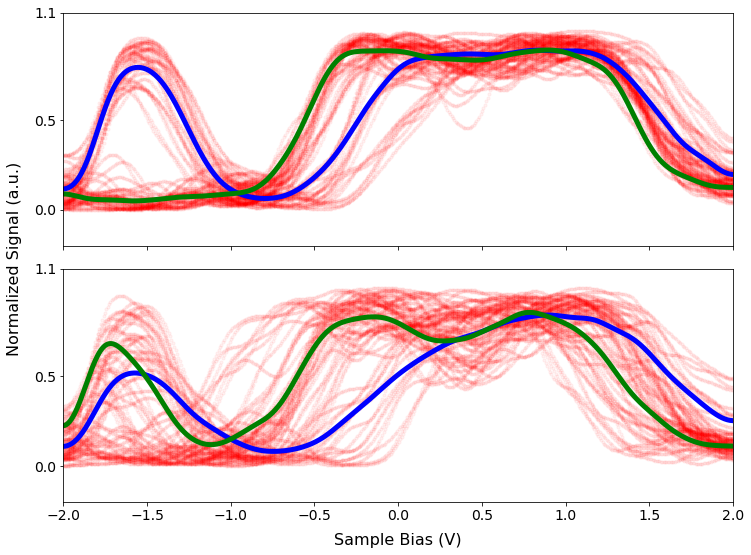

In [15]:
# re-load the cube
cube = np.load("./datacube.npy")

# plot a random image to do a quick check
# plt.imshow(cube[:, :, 65], cmap = 'plasma');

# plot spectra at regions where one of the right device has defect
z = cube.shape[2]
bias = np.linspace(-2, 2, z )

fig, (ax1, ax2) = plt.subplots(2, sharex = True)
fig.subplots_adjust(hspace = 0.1)
fig.set_size_inches(12,9)

fig.text(0.06, 0.5, 'Normalized Signal (a.u.)', va='center', rotation='vertical', fontsize = 16)
ax2.set_xlabel('Sample Bias (V)', fontsize = 16, labelpad = 10)

ax1.set_xlim(-2, 2)
ax2.set_xlim(-2, 2)
ax1.set_ylim(-0.2, 1)
ax2.set_ylim(-0.2, 1)

ax1.set_yticks([0, 0.5, 1.1])
ax2.set_yticks([0, 0.5, 1.1])
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
# ax1.set_title('Spectra from Normal Device')
# ax2.set_title('Spectra from Defected Device')

# Use guassian filter1d to smooth the digital data here. 
for i in range(80, 88):
    for j in range (25, 33):
        y_smooth = gaussian_filter1d(cube[i, j, :], sigma=10)
        ax1.scatter(bias, y_smooth, alpha = 0.05, color = 'r', s = 10) #, ls='-.');

for i in range(82, 90):
    for j in range (100, 108):
        y_smooth = gaussian_filter1d(cube[i, j, :], sigma=10)        
        ax2.scatter(bias, y_smooth, alpha = 0.05, color = 'r', s = 10)#, ls='--');


# plot the representative spectrum
y11 = gaussian_filter1d(cube[82:100, 26:29, :].mean(axis = (0,1)), sigma=10)
ax1.plot(bias, y11 , color = 'blue', lw = 5)

y12 = gaussian_filter1d(cube[82:100, 30:32, :].mean(axis = (0,1)), sigma=10)
ax1.plot(bias, y12 , color = 'green', lw = 5)

y21 = gaussian_filter1d(cube[82:100, 100:103, :].mean(axis = (0,1)), sigma=10)
ax2.plot(bias, y21 , color = 'blue', lw = 5)

y22 = gaussian_filter1d(cube[82:100, 104:105, :].mean(axis = (0,1)), sigma=10)
ax2.plot(bias, y22, color = 'green', lw = 5)
# fig.savefig(fname = 'Compared Spectra.png', dpi=2**8)

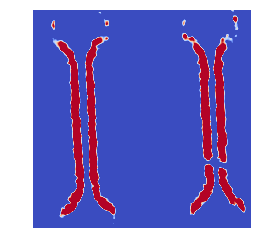

In [18]:
fig, ax = plt.subplots()
ax.imshow(cube[:, :, 46], 
          origin = 'upper',
          cmap = 'coolwarm',
          vmin = 0.3,
          vmax = 0.5,
          interpolation = 'bicubic')
ax.set_axis_off()
plt.show()

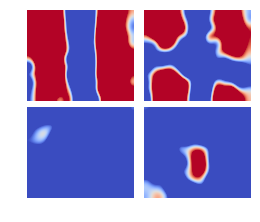

In [43]:
fig, ax = plt.subplots(2,2)
fig.subplots_adjust(hspace = -0.2, wspace = 0.1)
fig.set_size_inches(4,4)
kwargs = dict(origin = 'upper',
              cmap = 'coolwarm',
              vmin = 0.3,
              vmax = 0.5,
              interpolation = 'bicubic')
ax[0][0].imshow(cube[81:93, 24:38, 46], **kwargs)
ax[0][0].set_axis_off()

ax[0][1].imshow(cube[83:95, 100:114, 46], **kwargs)
ax[0][1].set_axis_off()

ax[1][0].imshow(cube[81:93, 24:38, 110], **kwargs)
ax[1][0].set_axis_off()

ax[1][1].imshow(cube[83:95, 100:114, 110], **kwargs)
ax[1][1].set_axis_off()


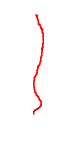

In [19]:
# coordinate flip, this is to generate a plot used for the presentation
fig, ax = plt.subplots()
fig.set_size_inches(0.2, 2)
ax.plot(cube[95:105, 20:30, :].mean(axis = (0,1)), range(484), color = 'red')
ax.set_axis_off()

In [ ]:
'''
use Mayavi for high-dimensional visualization
use mayavi GUI to open this script, don't run here
'''

# from mayavi import mlab
# cube = np.load("./datacube.npy")
# n, m, l = cube.shape

# X, Y, Z = np.mgrid[0.:n, 0.:m, 0.:l]
# X *= 1. / n
# Y *= -1. / m  # flip Y
# Y += 2  # Mayavi seems to have an offset
# Z *= 1. / l

# scalar_field = mlab.pipeline.scalar_field(X, Y, Z, cube)

# scalar_cut_plane_1 = mlab.pipeline.scalar_cut_plane(
#     scalar_field, plane_orientation="z_axes")
# scalar_cut_plane_1.implicit_plane.widget.origin = [.5, .5, .5]

# del X, Y, Z, cube